# Word2vec
可參考 
* http://nbviewer.jupyter.org/url/b81.org/s/math_intro11.ipynb

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np


In [2]:
# 設定環境變數來控制 keras, theano
import os
os.environ['KERAS_BACKEND']="tensorflow"
os.environ['THEANO_FLAGS']="floatX=float32, device=cuda"

### 用 jieba 斷詞

In [3]:
import jieba
jieba.set_dictionary('dict.txt.big')
" - ".join(jieba.cut("今天天氣很好"))

Building prefix dict from /home/tjw/src/HackNTU_Data_2017/Week08/dict.txt.big ...
Loading model from cache /tmp/jieba.uabe345d172aa2c353a2c9ed1c2ff896a.cache
Loading model cost 1.005 seconds.
Prefix dict has been built succesfully.


'今天天氣 - 很 - 好'

## 下載資料

In [4]:
if not os.path.isfile("sdyxz_all.txt"):    
    with open("sdyxz_all.txt","w") as outf:
        for i in range(1, 41):
            r = urlopen('http://www.millionbook.net/wx/j/jingyong/sdyxz/%03d.htm'%i)
            html = r.read().decode('cp950', "ignore")
            bs = BeautifulSoup(html, 'lxml')
            text = bs.findAll('td')[6].get_text()
            if len(text)<100:
                print("error")
                break
            print (i, len(text))
            outf.write(text)

In [5]:
# 忽略不要的詞
ignore_words = set("""the
of
is
and
to
in
that
we
for
an
are
by
be
as
on
with
can
if
from
which
you
it
this
then
at
have
all
not
one
has
or
that
的
了
和
是
就
都
而
及
與
著
或
一個
沒有
你
我
他
她
我們
你們
妳們
他們
她們
是否""".split("\n"))|set("，。*「」：？\n\u3000！、…』『《》-")

# 自訂辭典
jieba.add_word("黃蓉")
jieba.suggest_freq("黃蓉", True)
jieba.add_word("郭靖")
jieba.suggest_freq("郭靖", True)
with open("sdyxz_all.txt", "r") as f:
    words = [w for w in jieba.cut(f.read()) if w not in ignore_words]
print("len=", len(words))
print(words[:100])

len= 384051
['第一回', '風雪', '驚變', '錢塘江', '浩浩', '江水', '日日夜夜', '無窮', '無休', '從', '臨安', '牛家村', '邊', '繞過', '東流', '入海', '江畔', '一排', '數十株', '烏', '柏樹', '葉子', '似', '火燒', '般紅', '正是', '八月', '天時', '村前村後', '野草', '剛', '起始', '變黃', '一抹', '斜陽', '映照', '之下', '更增', '幾分', '蕭索', '兩株', '大', '松樹', '下圍', '一堆', '村民', '男男女女', '十幾個', '小孩', '正自', '聚精會神', '聽', '瘦削', '老者', '說話', '那', '說話', '人五', '十來', '歲', '年紀', '一件', '青布', '長袍', '早洗', '得', '褪成', '藍灰色', '只', '聽', '兩片', '梨花', '木板', '碰', '幾下', '左手', '中', '竹棒', '在', '一面', '小', '羯鼓', '上', '敲起', '得', '得', '連聲', '唱道', '小桃', '無主自', '開花', '煙草', '茫茫', '帶', '晚鴉', '幾處', '敗垣圍', '故井', '向來', '一一']


### 先處理掉少用字

In [6]:
# 總共有多少種字？
len(set(words))

47134

我們只考慮最常用的 10000 字， 其他字用 UNK 取代

In [7]:
import collections
# 先統計字數
counter = collections.Counter(words)
# 可以看一下 counter 是的內容

In [8]:
def sep_words(words):
    for w in words:
        if counter[w]<3:
            for c in w:
                yield c
        else:
            yield w
words = list(sep_words(words))
len(words)

434741

In [9]:
counter = collections.Counter(words)


In [10]:
# 最常見的 30 個字
counter.most_common(30)

[('道', 7119),
 ('在', 5042),
 ('郭靖', 3364),
 ('也', 3086),
 ('不', 3050),
 ('得', 2640),
 ('又', 2622),
 ('這', 2561),
 ('那', 2524),
 ('黃蓉', 2493),
 ('去', 2225),
 ('上', 2098),
 ('一', 2001),
 ('人', 1916),
 ('中', 1867),
 ('說', 1857),
 ('卻', 1777),
 ('有', 1728),
 ('來', 1697),
 ('已', 1682),
 ('到', 1678),
 ('見', 1559),
 ('聽', 1548),
 ('但', 1504),
 ('要', 1452),
 ('叫', 1320),
 ('向', 1300),
 ('大', 1234),
 ('之', 1225),
 ('好', 1187)]

In [11]:
vocabulary_size = sum(x>2 for x in counter.values())
print(vocabulary_size)
wordfreq = counter.most_common(vocabulary_size-1)


# 建立 編號: 字 的對照表
num2word = ['UNK'] + [w for (w, _) in wordfreq]
freq = np.array([0]+[n for (_, n) in wordfreq], dtype="float64")
freq[0] = len(words) - freq.sum()
# 建立一個 字: 編號 的對照表
word2num = {w: i for i, w in enumerate(num2word)}

# 把 words 轉成對定的編號
data = np.array([word2num.get(word, 0) for word in words])
# 不需要 words 了
del words
del wordfreq
freq[:10]

17179


array([ 1381.,  7119.,  5042.,  3364.,  3086.,  3050.,  2640.,  2622.,
        2561.,  2524.])

看一下目前的狀況

In [12]:
print(data[:20])
print(" - ".join(num2word[n] for n in data[:20]))

[  497    13   144  7773   464   914 11603  4632  4632  4736 13921  4768
    64  2539    56   674   869   438  4238   577]
第 - 一 - 回 - 風雪 - 驚 - 變 - 錢塘江 - 浩 - 浩 - 江水 - 日日夜夜 - 無窮 - 無 - 休 - 從 - 臨安 - 牛家村 - 邊 - 繞過 - 東


生成 skip-gram 模型的 batch

keywords skipgram, cbow, n-gram

In [13]:
import keras.backend as K

Using TensorFlow backend.


In [14]:
from keras.layers import Embedding, Dense, Flatten, Input
from keras.models import Sequential, Model
import keras.backend as K
import tensorflow as tf

# vector 的維度
embedding_size = 100

# 這其實只是線性映射，只不過輸入不是 one hot 而是 integer， 所以等同查表
word2vec = Sequential()
word2vec.add(Embedding(vocabulary_size, embedding_size, input_length=1))
word2vec.add(Flatten())
train_input = word2vec.inputs[0]
embeddings = word2vec.layers[0].embeddings 

# 對應到的 context
train_labels = Input(shape=(1,), dtype="int32")

# 這裡利用 tensorflow 的 nce_loss
nce_W = K.variable(K.random_normal((vocabulary_size, embedding_size),stddev=(embedding_size)**-0.5))
loss = K.mean(tf.nn.nce_loss(
                     weights=nce_W,
                     biases=K.zeros((vocabulary_size,)),
                     labels=train_labels,
                     inputs=word2vec.output,
                     num_sampled=64, # Number of negative examples to sample.
                     num_classes=vocabulary_size))

# 利用 tensorflow 的 optimizer
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# 之後要拿來檢驗的例子
valid_examples = np.array([word2num[x] for x in ["郭靖", "黃蓉", "聽", "梅超風", "自己", "武功"]])
#valid_examples = np.array(np.random.choice(100, size=16, replace=False)+1)
valid_size = len(valid_examples)
valid_dataset = K.constant(valid_examples[:, None], "int32")
valid_embeddings = word2vec(valid_dataset)

# 正規化 embeddings, 來找 nearest neighbor 
normalized_embeddings = K.l2_normalize(embeddings, 1)
similarity = K.dot(valid_embeddings, K.transpose(normalized_embeddings))

# Add variable initializer.
init = tf.global_variables_initializer()

In [15]:
def skipgram_batch(data, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window    
    context_length = skip_window*2+1
    X = np.ndarray(shape=batch_size, dtype=np.int32)
    Y = np.ndarray(shape=batch_size, dtype=np.int32)
    idx = 0
    while True:
        for i in range(0, batch_size, num_skips):
            X[i:i+num_skips] = data[idx+skip_window]            
            context = data[idx:idx+context_length][np.arange(context_length) != skip_window]        
            # subsampling 機率
            #p = np.ones(2*skip_window)/2/skip_window
            Y[i:i+num_skips] = np.random.choice(context, size=num_skips, replace=False)
            idx = (idx+1)%(len(data)-context_length)
        yield X[:, None], Y
# 測試看看
X,Y = next(skipgram_batch(data, 20, 4, 3))
for x,y in zip(X, Y):
    print("{} -> {}".format(num2word[x[0]], num2word[y]) )

風雪 -> 回
風雪 -> 一
風雪 -> 變
風雪 -> 第
驚 -> 變
驚 -> 回
驚 -> 浩
驚 -> 錢塘江
變 -> 錢塘江
變 -> 風雪
變 -> 驚
變 -> 浩
錢塘江 -> 風雪
錢塘江 -> 浩
錢塘江 -> 浩
錢塘江 -> 江水
浩 -> 浩
浩 -> 變
浩 -> 錢塘江
浩 -> 江水


In [16]:
import time
t0 = time.time()
batch_gen = skipgram_batch(data, batch_size=128, num_skips=8, skip_window=7)
with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    for step in range(0,200001):
        X,Y = next(batch_gen)
        feed_dict = {train_input: X, train_labels: Y[:, None]}
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        if step >0 and step %10000 == 0:
            print(step, "average loss", average_loss/2000, time.time()-t0)
            average_loss = 0
        if step % 50000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = num2word[valid_examples[i]]
                nearest = (-sim[i, :]).argsort()[1:8 + 1]
                print(valid_word, [num2word[x] for x in nearest])
    final_embeddings = embeddings.eval()
    final_normalized_embeddings = normalized_embeddings.eval()
    

郭靖 ['三股', '以待', '種種', '糞', '今夜', '公證', '冷然', '下擊']
黃蓉 ['欺蒙', '覓', '北歸', '老實', '親來', '金兵', '才智', '夫妻倆']
聽 ['淋', '許給', '直流', '夾層', '粗索', '柔腸百轉', '不肖', '伸展']
梅超風 ['大樹', '兩個', '手忙腳亂', '飽學', '半截', '紛至沓來', '險些兒', '秀髮']
自己 ['酒肉', '振臂', '三來', '怯', '十二株', '變掌', '篤', '初二']
武功 ['先父', '幫著', '東首', '千人隊', '座', '寄', '花船', '圖形']
10000 average loss 126.320705084 16.765474557876587
20000 average loss 31.7116507117 32.630695819854736
30000 average loss 26.9360071319 46.96360421180725
40000 average loss 25.6854510529 63.41709804534912
50000 average loss 25.5846362678 79.24905300140381
郭靖 ['黃蓉奇', '姊姊', '點點頭', '未動', '提高', '老賊', '箭桿', '幫著']
黃蓉 ['生火', '天井', '思潮起伏', '磕頭', '瞧見', '央求', '出神', '一竅不通']
聽 ['有人', '隱隱', '傳來', '聲', '東邊', '這話', '聲音', '一陣']
梅超風 ['四根', '惡狠狠', '鳩', '拳頭', '大缸', '劉氏', '北國', '飛向']
自己 ['固然', '辨', '此刻', '甚至', '事務', '技藝', '顯', '虛名']
武功 ['未必', '高強', '所', '功夫', '真經', '看來', '其實', '武']
60000 average loss 25.3992454354 92.82237935066223
70000 average loss 25.3986436303 106.30203795433044
80000 averag

In [17]:
def find_sim(v, num=10):
    if isinstance(v, str):
        v = w2v(v)
    return [num2word[x] for x in  (final_normalized_embeddings @ v).argsort()[-num-1:-1][::-1]]
def w2v(w):
    return final_embeddings[word2num.get(w, 0)] 
find_sim(w2v('黃藥師'))

['神妙', '造極', '侍奉', '遺訓', '他素', '學藝', '心地', '素知', '難怪', '最強']

In [18]:
find_sim('吃')

['菜', '飯菜', '飯', '吃飯', '粥', '麵', '幾根', '鹹', '店小二', '偏生']

In [19]:
find_sim(w2v('西毒')+w2v('洪七公')-w2v('北丐'))

['回過', '急退', '搖手', '打岔', '招呼', '慘然', '治傷', '響頭', '沒空', '來罷']

In [20]:
find_sim( w2v('郭靖')+(w2v('穆念慈')-w2v('楊康')) )

['穆念慈', '大屋', '小妹子', '下樓', '還不給', '失陪', '楊大哥', '傷勢', '你定', '飛得']

In [21]:
find_sim( w2v('洪七公')+(w2v('蛤蟆功')-w2v('歐陽鋒')) )

['蛤蟆功', '寶血', '一陽指', '使詐', '化開', '極了', '他命', '打下', '十八掌', '一抹']

In [22]:
find_sim(w2v('吃')- w2v("飯")+w2v("酒"))

['酒', '喝', '斟', '一碗', '飽', '一大口', '壺', '討', '葫蘆', '怒色']

In [23]:
# 用 t-sne 降低維度
from sklearn.manifold import TSNE
samples = 500
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(final_embeddings[:samples])
labels = num2word[1:samples]

In [24]:
# 從 00Download.ipynb 來的
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os.path
from urllib.request import urlopen
def download_req(req, filename):
    total = int(req.getheader("Content-Length"))
    with open(filename,'wb') as f:
        i = 0
        for data in iter(lambda: req.read(8192), b""):  
            i+=1
            f.write(data)
            print("\rdownloading: %5.1f%%"%(i*8192*100.0/total), end="")

# 字體下載
font_filename = 'NotoSansCJKtc-hinted.zip'
font_url = "https://noto-website-2.storage.googleapis.com/pkgs/"+font_filename
# 改變這行才能真正下載
if not (os.path.isfile(font_filename) and os.path.getsize(font_filename)==121247052):
    with urlopen(font_url) as req:
        download_req(req, "NotoSansCJKtc-hinted.zip")
# Extract Font files
import zipfile
with zipfile.ZipFile(font_filename) as zf:
    for f in zf.namelist():
        if f.endswith('.otf'):
            print("extract", f)
            zf.extract(f)

fp = matplotlib.font_manager.FontProperties(fname = 'NotoSansCJKtc-Regular.otf')
matplotlib.font_manager.fontManager.ttffiles.append(fp.get_file())
font_entry = matplotlib.font_manager.FontEntry(fp.get_file(), name=fp.get_name(),
                                               style=fp.get_style(), variant=fp.get_variant(),
                                              weight=fp.get_weight(), stretch=fp.get_stretch(), size=fp.get_size())

matplotlib.font_manager.fontManager.ttflist.append(font_entry)
plt.rcParams['font.family'] = fp.get_name()

extract NotoSansCJKtc-Black.otf
extract NotoSansCJKtc-Bold.otf
extract NotoSansCJKtc-DemiLight.otf
extract NotoSansCJKtc-Light.otf
extract NotoSansCJKtc-Medium.otf
extract NotoSansCJKtc-Regular.otf
extract NotoSansCJKtc-Thin.otf
extract NotoSansMonoCJKtc-Bold.otf
extract NotoSansMonoCJKtc-Regular.otf


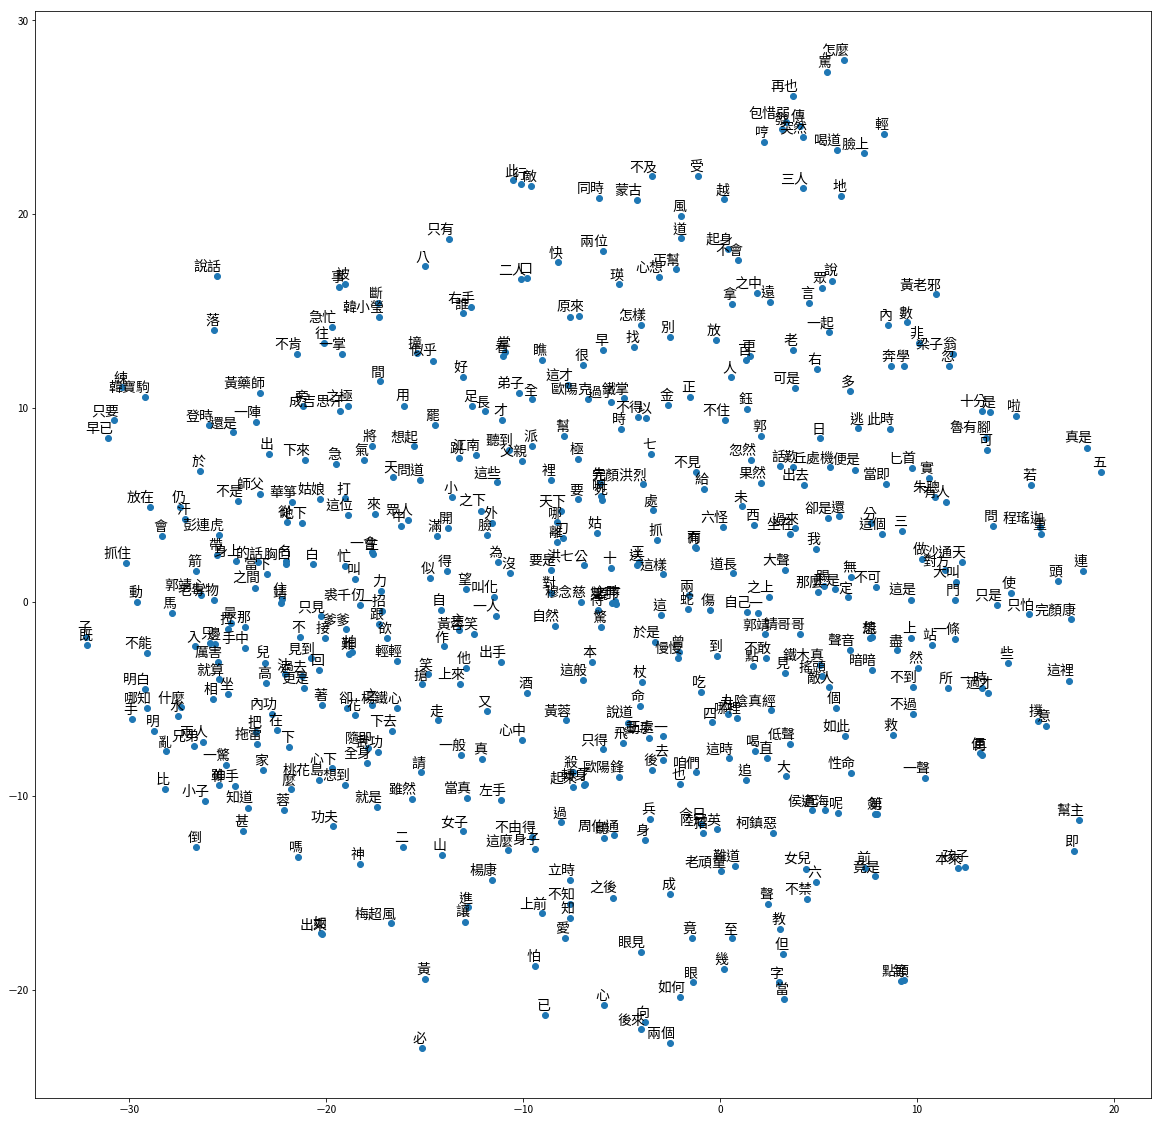

In [25]:
# 畫出來

plt.figure(figsize=(20,20))
plt.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1])
for i, label in enumerate(labels):
    x, y = low_dim_embs[i]
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=14,
                 ha='right',
                 va='bottom')